<a href="https://colab.research.google.com/github/AlexandreCamillo/AlgoritmosGrafos/blob/main/AlgGraf_PLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos e Grafos




## Código Base

In [ ]:
#@title #### (Imports e Helpers)
%tensorflow_version 1.x  # For Google Colab only.

from graph_nets import utils_np

import matplotlib.pyplot as plt
import networkx as nx

from google.colab import files
import io
import re
import random
import copy
import itertools
from functools import reduce

def listaAdjDeTxt (arquivo):
  texto = arquivo.decode("utf-8")
  listaAdj = dict()
  for l in texto.split('\n'):
    if(not l): continue
    v, rawAdj = re.split('[ ]=[ ]?', l)

    if(rawAdj): adj = rawAdj.split(' ')
    else: adj = []

    listaAdj[v] = adj
  return listaAdj

def draw_graph(data_dict, graph_label):
  graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax, graph_label)

def plot_graph_networkx(graph, ax, graph_label='Grafo', pos=None):
  node_labels = {node: "{}".format(data.get("features", None)[0])
                 for node, data in graph.nodes(data=True)
                 if data.get("features", None) is not None}
  node_colors = [ data.get("features", None)[1]
                 for node, data in graph.nodes(data=True)
                 if data.get("features", None) is not None]
  if pos is None:
    pos = nx.spring_layout(graph)
    # pos = nx.nx_pydot.pydot_layout(graph, prog='dot')
    # pos = nx.spiral_layout(graph)
  nx.draw_networkx(
      graph, 
      pos, 
      ax=ax,
      label=graph_label,
      font_weight='bold', 
      node_size=350, 
      node_color=node_colors, 
      labels=node_labels,
      arrowsize=20,
      linewidths=2.0,
      width=2.0
  )
  plt.text(0.05, 0.95, graph_label, transform=ax.transAxes, fontsize=15)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos



`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # For Google Colab only.`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


### Vertice

In [ ]:
class Vertice:

    def __init__(self, nome, grafo):
        self.nome = nome
        self.vizinhanca = []
        self.grafo = grafo
        self.cor = 1


    def setVizinhanca(self, grafo):
      self.vizinhanca = []
      for vizinhoNome in grafo.listaAdj.get(self.nome):
        vizinho = grafo.findVertice(vizinhoNome)
        if vizinho != None:
          self.vizinhanca.append(vizinho)
        else:
          raise Exception(f'Não é possível adicionar vertice {vizinhoNome} não inicializado à vizinhança de {self.nome}')

    def getVizinhancaNomes(self):
      return list( map((lambda v: v.nome), self.vizinhanca))

    def getInversoVizinhanca(self, grafo):
      inv = []
      for v in grafo.vertices:
        if self in v.vizinhanca:
          inv.append(v)
      return inv

    def grau(self):
      return len(self.vizinhanca)

    def __str__(self):
      vizinhanca = str(list( map((lambda v: v.nome), self.vizinhanca)))
      return '\n<{}: {} - {}>\n'.format(self.__class__.__name__, self.nome, vizinhanca)

    def __repr__(self):
      vizinhanca = str(list( map((lambda v: v.nome), self.vizinhanca)))
      return '\n<{}: {} - {}>\n'.format(self.__class__.__name__, self.nome, vizinhanca)


### Grafo


In [ ]:

class Grafo:
    def __init__(self, nome, listaAdjacencias = {}):
      self.nome = nome
      self.listaAdj = copy.deepcopy(listaAdjacencias)
      self.vertices = []
      self.arestas = []
      self.cliques = []
      self.tam_clique_max = 0
      if(listaAdjacencias): self.setListaAdjacencias(listaAdjacencias)
      

    def setListaAdjacencias(self, listaAdjacencias = {}):
      self.listaAdj = copy.deepcopy(listaAdjacencias)
      self.vertices = []
      self.arestas = []
      for idx, verticeNome in enumerate(listaAdjacencias.keys()):
        self.addVertice(verticeNome)

      for idx, verticeNome in enumerate(listaAdjacencias.keys()):
        v = self.findVertice(verticeNome)
        if v != None:
          v.setVizinhanca(self)

        else:
          raise Exception(f'Vertice {verticeNome} não inicializado')
      self.__setArestas()

    def findVertice(self, verticeNome):
      return next(filter(lambda v:( v.nome == verticeNome and v.grafo.nome == self.nome), self.vertices), None)

    def addVertice(self, verticeNome):
        if not self.findVertice(verticeNome):
            v = Vertice(verticeNome, self)
            if verticeNome not in self.listaAdj:
              self.listaAdj[verticeNome] = []
            self.vertices.append(v)
        else:
            return f'{verticeNome} já existe no grafo'

    def remVertice(self, verticeNome):
      v = self.findVertice(verticeNome)
      if v:
          for invVizinho in v.getInversoVizinhanca(self):
            invVizinho.vizinhanca.remove(v)
            self.listaAdj[invVizinho.nome].remove(verticeNome) 
          self.vertices.remove(v)
          self.listaAdj.pop(verticeNome)
          self.__setArestas()
      else:
          return f'{verticeNome} já não existe no grafo'

    def findAresta(self, v1, v2):
      if((isinstance(v1, str) and isinstance(v2, str))): return next(filter(lambda a:( (a[0].nome == v1 and a[1].nome == v2) or (a[0] == v1 and a[1] == v2) ), self.arestas), None)
      return 'Os vertices inseridos devem ser do tipo str ou Vertice e precisam ser do mesmo tipo'

    def addAresta(self, v1: str, v2: str):
      if(not self.findVertice(v1) or not self.findVertice(v2)):
        return f'O vértice {v1 or v2} não pertence ao grafo {self.nome}'
      self.listaAdj[v1].append(v2)
      self.listaAdj[v1].sort()

      v = self.findVertice(v1)
      v.setVizinhanca(self)
      self.__setArestas()

    def remAresta(self, v1: str, v2: str):
      if(not self.findVertice(v1) or not self.findVertice(v2)):
        return f'O vértice {v1 or v2} não pertence ao grafo {self.nome}'
      self.listaAdj[v1].remove(v2)

      v = self.findVertice(v1)
      v.setVizinhanca(self)
      self.__setArestas()

    def isDirecionado(self):
      for v in self.vertices:
        for u in v.vizinhanca:
          if v not in u.vizinhanca:
            return True
      return False

    def isPerfeito(self):
      if(not self.isDirecionado()):
        self.setClique()
        nc = self.numCromatico()
        if(nc != self.tam_clique_max):
          self.draw()
          return f'O Grafo "{self.nome}" possui número cromático ({nc}) diferente do tamanho da clique máxima ({self.tam_clique_max}), logo {self.nome} não é perfeito. \n(É possível visualizar o desenho do grafo abaixo)'
        vertices = grafo.listaAdj.keys()
        combVerticesARemover = []
        for i in range(0, len(vertices) -1):
          combVerticesARemover.extend(list(map((lambda v: list(v)), list(itertools.combinations(vertices, i)))))
        i = 0
        subgrafosInduzidos = list()
        for verticesARemover in combVerticesARemover:
          g = Grafo(f'Subgrafo{i}', {})
          g.setListaAdjacencias(grafo.listaAdj)
          subgrafosInduzidos.append(g)
          for vertice in verticesARemover:
            subgrafosInduzidos[i].remVertice(vertice)
          del g
          i += 1
        count = 0
        verboseLog = False
        for subgrafo in subgrafosInduzidos:
          subgrafo.setClique()
          nc = subgrafo.numCromatico()
          if(not subgrafo.tam_clique_max == nc): 
            subgrafo.draw()
            return f'O subgrafo induzido {subgrafo.nome} do grafo {self.nome} possui número cromático ({nc}) diferente do tamanho da clique máxima ({subgrafo.tam_clique_max}), logo {self.nome} não é perfeito. \n(É possível visualizar o desenho do subgrafo abaixo)'
        return f'{self.nome} é Perfeito'
      return f'O Grafo "{self.nome}" é direcionado, então não pode ser um Grafo Perfeito'
    
    def setClique(self, clique = [], candidates = None, excluded = set(), count = 0):
        '''Algoritmo Bron–Kerbosch com pivot'''
        if (candidates == None): candidates = set(self.listaAdj.keys())
        count += 1
        if not candidates and not excluded:
            if len(clique) >= 1:
                self.cliques.append(clique)
                if (len(clique) > self.tam_clique_max): self.tam_clique_max = len(clique)
            return
        pivot = self.__pick_random(candidates) or self.__pick_random(excluded)
        for v in list(candidates.difference(self.listaAdj[pivot])):
            new_candidates = candidates.intersection(self.listaAdj[v])
            new_excluded = excluded.intersection(self.listaAdj[v])
            self.setClique(clique + [v], new_candidates, new_excluded, count)
            candidates.remove(v)
            excluded.add(v)
        return self.cliques

    def __pick_random(self, s):
        if s:
            return random.sample(s, 1)[0]


    def numCromatico(self):
      '''Algoritmo Welsh e Powell'''
      verticesOrdenados = self.vertices.copy()
      verticesOrdenados.sort(key=lambda v: v.grau(), reverse=True)
      
      verticesOrdenados = list(map((lambda v: v.nome), verticesOrdenados))
      
      CV = dict()
      nb = 0
      for v in verticesOrdenados:
        CV[v] = 0
      coloridos = list(filter(lambda k: CV[k] > 0, CV))
      vCopy = verticesOrdenados.copy()

      if verboseLog: print(f'Local - NumCr - naoVizinhosNaoColoridos - listaAdj[v] - coloridos')
      for v in verticesOrdenados:
        if CV[v] == 0:
          nb += 1
          CV[v] = nb
          self.findVertice(v).cor = nb
          coloridos = list(filter(lambda k: CV[k] > 0, CV))
          naoVizinhosNaoColoridos = sorted(set(verticesOrdenados).difference(self.listaAdj[v]).difference(coloridos), key=verticesOrdenados.index)
          if verboseLog: print('A', nb, v, naoVizinhosNaoColoridos, self.listaAdj[v], coloridos)
          while (len(naoVizinhosNaoColoridos) > 0):
            u = self.__takeVerticeMenorSaturacaoDaLista(naoVizinhosNaoColoridos, coloridos)

            while(len(list(filter(lambda v:(CV[v] == nb), self.listaAdj[u]))) > 0): 
              if(len(naoVizinhosNaoColoridos) == 0): break 
              u = self.__takeVerticeMenorSaturacaoDaLista(naoVizinhosNaoColoridos, coloridos)

            if(len(list(filter(lambda v:(CV[v] == nb), self.listaAdj[u]))) > 0): break 
            CV[u] = nb
            self.findVertice(u).cor = nb
            coloridos = list(filter(lambda k: CV[k] > 0, CV))
            naoVizinhosNaoColoridos = sorted(set(naoVizinhosNaoColoridos).difference(self.listaAdj[u]).difference(coloridos), key=verticesOrdenados.index)
            if verboseLog: print('B', nb, u, naoVizinhosNaoColoridos, self.listaAdj[u], coloridos)
      return nb
    
    def __takeVerticeMenorGrauDaLista(self, lista):
      qtd = None
      taked = None
      for v in lista:
        c = 0
        for u in sorted(set(lista).difference([v]), key=lista.index):
          if(self.findAresta(v, u)): c += 1
        if qtd == None or qtd > c:
          qtd = c
          taked = v
      if verboseLog: print(f'   C taked:{taked} lista:{lista}')
      if taked: lista.remove(taked)
      elif lista: taked = lista.pop(0)
      if verboseLog: print(f'   D taked:{taked} lista:{lista}')
      return taked

    def __takeVerticeMenorSaturacaoDaLista(self, lista, coloridos):
      qtd = None
      taked = None
      verticesBySaturation = {}
      for v in lista:
        c = 0
        if(not verticesBySaturation.get(c, None)): verticesBySaturation[c] = []
        for u in coloridos:
          if(self.findAresta(v, u)): 
            c += 1
            if(not verticesBySaturation.get(c, None)): verticesBySaturation[c] = []
        if verboseLog: print(f'      {v}:{c}:{qtd}')
        if qtd == None or qtd >= c:
          qtd = c
          verticesBySaturation[c].append(v)
      if verboseLog: print(f'   A taked:{taked} lista:{lista} coloridos:{coloridos} sat:{verticesBySaturation}')
      if len(verticesBySaturation[qtd]) > 1: 
        taked = self.__takeVerticeMenorGrauDaLista(verticesBySaturation[c])
        if not taked: taked = self.__takeVerticeMenorGrauDaLista(lista)
      else:
        taked = verticesBySaturation[qtd][0]
        lista.remove(taked)
      if verboseLog: print(f'   B taked:{taked} lista:{lista} coloridos:{coloridos} sat:{verticesBySaturation}')
      return taked
    
    def BFS(self, raiz):
      visitado = dict()
      bfs = dict()
      for v in self.listaAdj.keys():
        visitado[v] = False
        bfs[v] = []
      q = []
      q += [raiz]
      visitado[raiz] = True

      while len(q) > 0:
        v = self.findVertice(q.pop(0))

        for u in v.vizinhanca:
          if not visitado[u.nome]:
            visitado[u.nome] = True
            q += [u.nome]
            bfs[v.nome].append(u.nome)
      return bfs

    # UNDER CONSTRUCTION
    def DFS(self, raiz):
      visitado = dict()
      bfs = dict()
      for v in self.listaAdj.keys():
        visitado[v] = False
        bfs[v] = []
      q = []
      q += [raiz]
      visitado[raiz] = True

      while len(q) > 0:
        v = self.findVertice(q.pop(0))

        for u in v.vizinhanca:
          if not visitado[u.nome]:
            visitado[u.nome] = True
            q += [u.nome]
            bfs[v.nome].append(u.nome)
      return bfs

    # UNDER CONSTRUCTION
    def subjacente(self):
        subj = dict()

        for v in self.listaAdj.keys():
          subj[v] = []

        for v in self.listaAdj.keys():
          for u in self.listaAdj[v]:
              if u not in subj[v]: subj[v].append(u)
              if v not in subj[u]: subj[u].append(v)
        return subj


    def __setArestas(self):
      def reducer(acc, v):
        for w in v[1]:
          acc.append([v[0], w])
        return acc
      self.arestas = reduce(reducer, map((lambda v: [v, v.vizinhanca]), self.vertices), [])


    def __str__(self):
        return f'\n<Vertice: {self.nome} - {self.vertices}>\n'

    def draw(self):
      nodes = []
      senders = []
      receivers = []
      couleurs = ["#88dafd","#07bc4c","#f44336","#795548","#b3b3b3","#ff6096", "#ff9800", "#9c27b0"]
      for idx in range(len(self.vertices)):
        nodes.append([self.vertices[idx].nome, couleurs[self.vertices[idx].cor - 1]])
      for aresta in self.arestas:
        senders.append(self.vertices.index(aresta[0]))
        receivers.append(self.vertices.index(aresta[1]))
      data_dict = {
        "nodes": nodes,
        "senders": senders,
        "receivers": receivers,
      }

      draw_graph(data_dict, self.nome);


Tutorial da ferramenta que utilizei para desenhar os grafos: [Tutorial Graph Nets library](https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/graph_nets_basics.ipynb#scrollTo=rPPRpGpz1Hce)

In [ ]:
#@title #### Grafos de exemplo

g1 = { # G1
    'A': ['B','C'],
    'B': ['A','D'],
    'C': ['A','D'],
    'D': ['B','C','E'],
    'E': ['D','F'],
    'F': ['E','G','H'],
    'G': ['F','I'],
    'H': ['F','I'],
    'I': ['G','H']
}

g2 = { # G2
    'A': ['B','E','F'],
    'B': ['A','C','G'],
    'C': ['B','D','H'],
    'D': ['C','E','I'],
    'E': ['A','D','J'],
    'F': ['A','H','I'],
    'G': ['B','I','J'],
    'H': ['C','F','J'],
    'I': ['D','F','G'],
    'J': ['E','G','H']
}

g3 = { #Grafo do jayme 
    'A': ['B','H','I','J'],
    'B': ['A','C','D','E','H','J'],
    'C': ['B','D','E'],
    'D': ['B','C','E'],
    'E': ['B','C','D'],
    'F': ['G','H'],
    'G': ['F','H'],
    'H': ['A','B','F','G','I'],
    'I': ['A','H'],
    'J': ['A','B']
}

g4 = { # grafo simples de 2 componentes e uma ponte
    'A': ['B','C'],
    'B': ['A','C'],
    'C': ['A','B','G'],
    'D': ['I','E','F'],
    'E': ['D','F'],
    'F': ['D','E'],
    'G': ['C','H'],
    'H': ['G','I'],
    'I': ['H','D']
}

g5 = { # grafo de Paley -> Grafo perfeito
    'A': ['B', 'C', 'D', 'G'],
    'B': ['A', 'C', 'E', 'H'],
    'C': ['A', 'B', 'F', 'I'],
    'D': ['A', 'E', 'F', 'G'],
    'E': ['B', 'D', 'F', 'H'],
    'F': ['C', 'D', 'E', 'I'],
    'G': ['A', 'D', 'H', 'I'],
    'H': ['B', 'E', 'G', 'I'],
    'I': ['C', 'F', 'G', 'H']
}


g6 = { # ciclo de 5 vertices
    '1': ['2', '5'], 
    '2': ['1', '3'], 
    '3': ['2', '4'], 
    '4': ['3', '5'], 
    '5': ['1', '4']
}

### Grafo De Paley (Grafo Perfeito)#



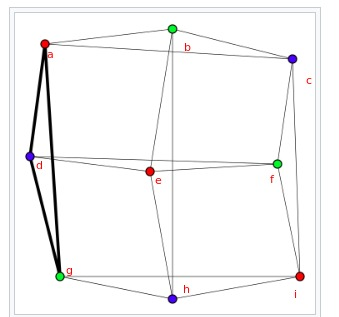

Para utilizar esse grafo utilize o grafo **g5** dos grafos de exemplo:
```
grafo = Grafo('Grafo de Paley', g5)
```


In [ ]:
#@title #### Aqui você pode fazer upload de arquivos com a lista de adjacências de um grafo

arquivo_entrada = list(files.upload().values())[0]
grafo = Grafo('Entrada', listaAdjDeTxt(arquivo_entrada))
grafo.draw()

G é Perfeito


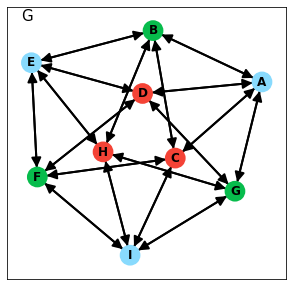

In [ ]:
#Grafos disponíveis para teste:
# g1, g2, g3, g4, g5, g6
grafo = Grafo('G', g5) 
verboseLog = False # Coloque True para obter mais detalhes do estado de cada iteração
grafo.setClique()
print(grafo.isPerfeito())
grafo.draw()